In [2]:
import os

# Lấy thư mục hiện tại
current_dir = os.getcwd()
print("Thư mục hiện tại:", current_dir)

# Lấy thư mục cha (trước 1 cấp)
parent_dir = os.path.dirname(current_dir)
print("Thư mục cha:", parent_dir)

Thư mục hiện tại: /home/schaffen/Workspace/Project/Plant_Disease_Classification/notebooks
Thư mục cha: /home/schaffen/Workspace/Project/Plant_Disease_Classification


In [3]:
"""
Scan the dataset in `data/raw` and print information per class:

- number of images per class
- image size statistics per class (min, max, mean, median)
- total images across all classes

Usage:
    python src/data/inspect_data.py --base-dir data/raw

Requires: Pillow (PIL)
"""
import os
import argparse
from collections import Counter, defaultdict
from statistics import mean, median
import json

try:
    from PIL import Image
except Exception:
    Image = None

IMAGE_EXTS = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.tif','.webp'}


def iter_image_files(folder, exts=IMAGE_EXTS):
    for entry in os.listdir(folder):
        path = os.path.join(folder, entry)
        if os.path.isfile(path):
            _, ext = os.path.splitext(entry)
            if ext.lower() in exts:
                yield path


def inspect_raw_data(base_dir='data/new'):
    if Image is None:
        raise RuntimeError('Pillow (PIL) is not installed. Install with `pip install pillow`.')

    if not os.path.exists(base_dir):
        raise FileNotFoundError(f"Base directory not found: {base_dir}")

    classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    classes.sort()

    summary = {}
    total_images = 0

    for cls in classes:
        cls_dir = os.path.join(base_dir, cls)
        sizes = []  # list of (width, height)
        corrupted = 0

        for img_path in iter_image_files(cls_dir):
            try:
                with Image.open(img_path) as im:
                    sizes.append(im.size)  # (width, height)
            except Exception:
                corrupted += 1

        count = len(sizes)
        total_images += count

        if count:
            widths = [s[0] for s in sizes]
            heights = [s[1] for s in sizes]

            size_counts = Counter(sizes)
            most_common_size, most_common_count = size_counts.most_common(1)[0]

            cls_summary = {
                'class': cls,
                'count': count,
                'corrupted_files': corrupted,
                'unique_sizes': len(size_counts),
                'most_common_size': {'size': f"{most_common_size[0]}x{most_common_size[1]}", 'count': most_common_count},
                'width': {
                    'min': min(widths),
                    'max': max(widths),
                    'mean': round(mean(widths), 2),
                    'median': median(widths),
                },
                'height': {
                    'min': min(heights),
                    'max': max(heights),
                    'mean': round(mean(heights), 2),
                    'median': median(heights),
                }
            }
        else:
            cls_summary = {
                'class': cls,
                'count': 0,
                'corrupted_files': corrupted,
                'unique_sizes': 0,
                'most_common_size': None,
                'width': None,
                'height': None,
            }

        summary[cls] = cls_summary

    return {'per_class': summary, 'total_images': total_images}


def print_summary(summary):
    per_class = summary['per_class']
    total = summary['total_images']

    print('\nDataset summary for data/raw\n' + '='*40)
    for cls, info in per_class.items():
        print(f"Class: {cls}")
        print(f"  Count: {info['count']}")
        if info['corrupted_files']:
            print(f"  Corrupted/unreadable files: {info['corrupted_files']}")
        if info['most_common_size']:
            ms = info['most_common_size']
            print(f"  Unique image sizes: {info['unique_sizes']}")
            print(f"  Most common size: {ms['size']} ({ms['count']} images)")
            w = info['width']
            h = info['height']
            print(f"  Width  - min: {w['min']}, max: {w['max']}, mean: {w['mean']}, median: {w['median']}")
            print(f"  Height - min: {h['min']}, max: {h['max']}, mean: {h['mean']}, median: {h['median']}")
        print('-'*40)

    print(f"Total images (all classes): {total}\n")


def main():
    # parser = argparse.ArgumentParser(description='Inspect dataset in data/raw and print image stats per class')
    # parser.add_argument('--base-dir', default='data/new', help='Path to the raw data folder (default: data/raw)')
    # parser.add_argument('--json', help='Write summary to JSON file at this path')
    # args = parser.parse_args()

    try:
        summary = inspect_raw_data(f"{parent_dir}/data/new")
        print_summary(summary)
        
    except Exception as e:
        print(f"Error: {e}")


if __name__ == '__main__':
    main()


Error: Base directory not found: /home/schaffen/Workspace/Project/Plant_Disease_Classification/data/new


powdery: 76 ảnh
rust: 50 ảnh
anthracnose: 41 ảnh
sooty_mold: 50 ảnh
spot: 50 ảnh
healthy: 50 ảnh
yellow: 40 ảnh


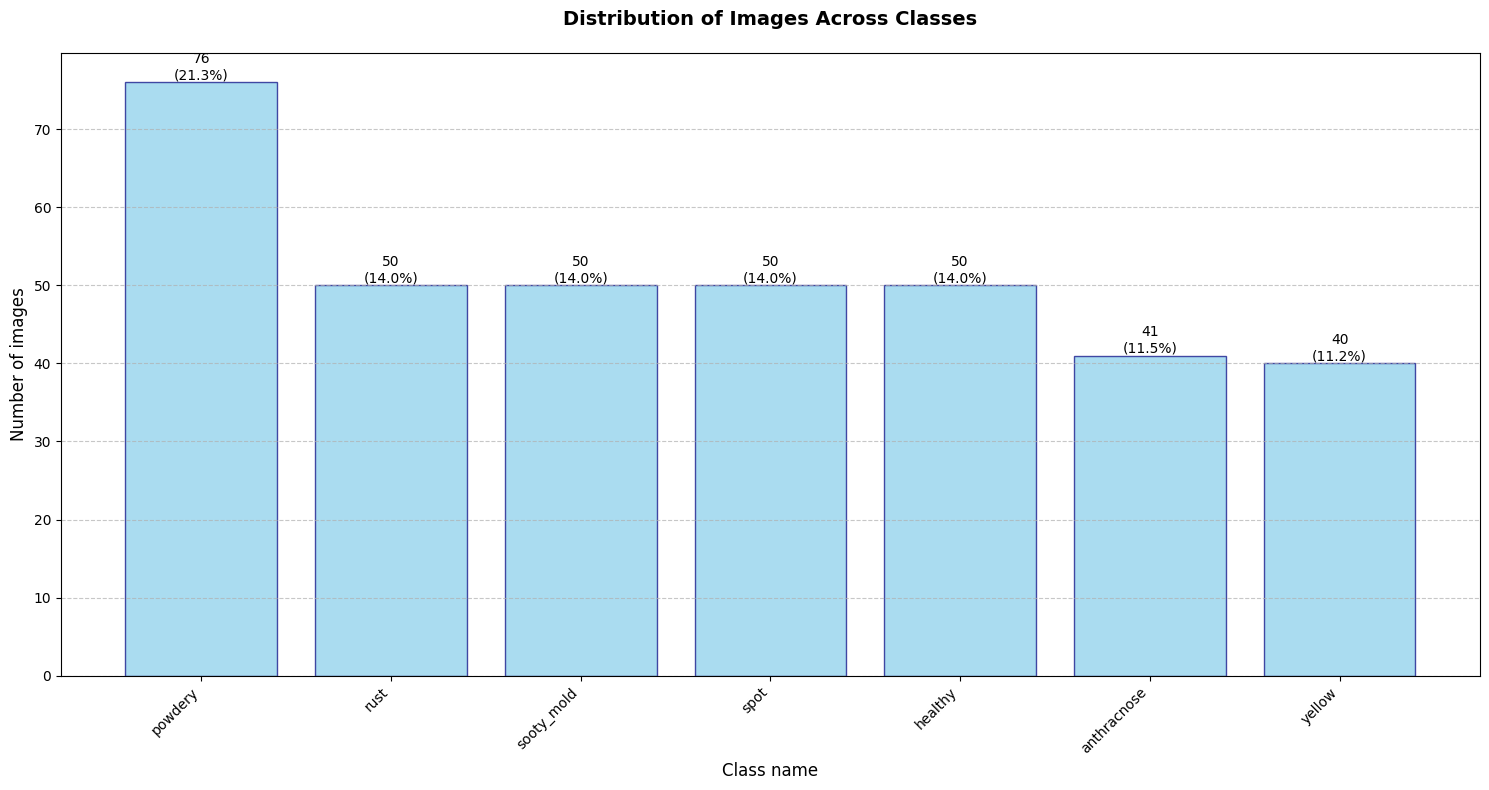


CHI TIẾT PHÂN BỐ:
powdery        :    76 ảnh (21.29%)
rust           :    50 ảnh (14.01%)
sooty_mold     :    50 ảnh (14.01%)
spot           :    50 ảnh (14.01%)
healthy        :    50 ảnh (14.01%)
anthracnose    :    41 ảnh (11.48%)
yellow         :    40 ảnh (11.20%)
TỔNG           :   357 ảnh


In [4]:
import os
import matplotlib.pyplot as plt
from pathlib import Path

# Đường dẫn đến thư mục chứa data
data_dir = Path(f"{parent_dir}/data/raw")  # Thay đổi đường dẫn nếu cần

# Dictionary để lưu số lượng ảnh của mỗi class
class_counts = {}

# Duyệt qua các class trong thư mục raw
for class_dir in data_dir.iterdir():
    if class_dir.is_dir():
        class_name = class_dir.name
        
        # Đếm số file ảnh (jpg, png, jpeg, webp)
        image_files = list(class_dir.glob('*.jpg')) + \
                     list(class_dir.glob('*.png')) + \
                     list(class_dir.glob('*.jpeg')) + \
                     list(class_dir.glob('*.webp')) + \
                     list(class_dir.glob('*.JPG'))
        
        count = len(image_files)
        class_counts[class_name] = count
        print(f"{class_name}: {count} ảnh")

# Tạo biểu đồ
plt.figure(figsize=(15, 8))

# Sắp xếp classes theo số lượng ảnh (giảm dần)
sorted_items = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
classes, counts = zip(*sorted_items)

# Tạo bar chart
bars = plt.bar(classes, counts, color='skyblue', edgecolor='navy', alpha=0.7)

# Thêm giá trị và phần trăm lên đầu mỗi cột
total_images = sum(counts)
for bar in bars:
    height = bar.get_height()
    percentage = (height / total_images) * 100
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}\n({percentage:.1f}%)',
             ha='center', va='bottom', fontsize=10)

# Trang trí biểu đồ
plt.title('Distribution of Images Across Classes', pad=20, fontsize=14, fontweight='bold')
plt.xlabel('Class name', fontsize=12)
plt.ylabel('Number of images', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)


# Điều chỉnh layout để tránh bị cắt
plt.tight_layout()

plt.show()

# In thông tin chi tiết
print("\n" + "="*50)
print("CHI TIẾT PHÂN BỐ:")
print("="*50)
for class_name, count in sorted_items:
    percentage = (count / total_images) * 100
    print(f"{class_name:15s}: {count:5d} ảnh ({percentage:.2f}%)")
print("="*50)
print(f"{'TỔNG':15s}: {total_images:5d} ảnh")